# Optimización Numérica
Proyecto final - Otoño 2019

# Neural Style Transfer
Neural Style Transfer (NST) se refiere a una clase de algoritmos que manipulan imágenes digitales o videos para adoptar la apariencia o el estilo visual de otra imagen. Los algoritmos NST se caracterizan por el uso de deep neural networks para realizar la transformación de la imagen.

A continuación se presenta una implementación basada en los artículos: *A Neural Algorithm of Artistic Style* (https://arxiv.org/abs/1508.06576) y *Perceptual Losses for Real-Time Style Transfer and Super-Resolution* (https://arxiv.org/abs/1603.08155), y en el repositorio: https://github.com/slavivanov/Style-Tranfer.



## Librerias especiales usadas:
**TensorFlow**: Es una plataforma de código abierto para Machine Learning, tiene todo un ecosistema integral y flexible de herramientas, bibliotecas y recursos comunitarios.

**Keras**: Es una API de redes neuronales, de alto nivel, escrita en Python y capaz de ejecutarse sobre TensorFlow, CNTK o Theano. Fue desarrollada para permitir la experimentación rápida y ser capaz de pasar de la idea al resultado con el menor retraso posible.
Las aplicaciones Keras son modelos de deep learning que están disponibles junto con pesos pre-entrenados. Estos modelos se pueden usar para predicción, extracción de características y ajustes.

**OS**: El módulo del sistema operativo en python proporciona funciones para interactuar con el sistema operativo. OS, esta en los módulos de utilidad estándar de Python.

In [1]:
#Importamos las librerias
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os
import tensorflow as tf
import numpy as np
from PIL import Image
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import imagenet_utils
from keras import backend as K
from scipy.ndimage.filters import gaussian_filter
from IPython.display import clear_output, HTML
from IPython.display import display, Image
from functools import partial
import utils
from importlib import reload
reload(utils)
from utils import *
from IPython.core.debugger import Tracer
from display_graph import display_graph
import pprint
import time
from scipy.misc import imsave

%matplotlib inline

Using TensorFlow backend.


## Carga de imágenes

In [2]:
# Tamaño de la imagen mostrada
image_size = (400, 400)

In [3]:
def random_image(size,):
    '''Genera una imagen de ruido aleatorio y la devuelve como matriz de numpy
        Args:
            size: Dimensiones del la imágen resultante
    '''
    width, height = size
    # Generar una imagen de ruido aleatorio.
    # 3 es el número de canales (RGB) en la imagen.
    img = np.random.random(size=(width, height, 3))
    img_array = img * 256
    return img_array

In [4]:
def load_image(size, filename=None):
    '''Carga una imágen y la devuelve como matriz de numpy
        Args:
            size: Dimensiones del la imágen resultante
            filename: La dirección de la imágen a cargar
    '''
    width, height = size

    if not filename:
        raise ValueError(
            'Si no se quiere una imágen aleatoria, se necesita especificar el nombre de la imagen')
    # Cargar la imágen
    img = PIL.Image.open(filename)
    img = img.resize((width, height))
    img_array = np.asarray(img.copy())
    return img_array

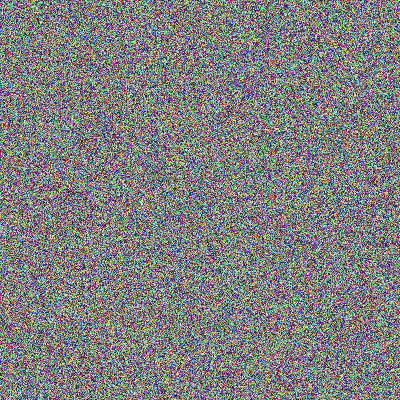

In [5]:
# Ejemplo de una imagen con ruido aleatorio
image = random_image(size=image_size)
show(image)

## Cargar el modelo

In [6]:
#Incializamos variables

#Un "Graph" contiene un conjunto de objetos tf.Operation (que representan unidades de cálculo) 
#y tf.Tensor (que representan las unidades de datos que fluyen entre operaciones)
graph = tf.Graph()

#TensorFlow usa tf.ConfigProto() para configurar la sesión.
config = tf.ConfigProto()

#Un objeto Session encapsula el entorno en el que se ejecutan los objetos tf.Operation y 
#se evalúan los objetos Tensor. 
#A diferencia de Session, InteractiveSession se convierte en la sesión predeterminada

#Creamos una sesión de TensorFlow y la registramos con Keras. Esto significa que 
#Keras usará la sesión que registramos para inicializar todas las variables que crea 
#internamente.
sess = tf.InteractiveSession(graph=graph, config=config)
K.set_session(sess)

# Keras flag - prueba, no entrenamiento
K.set_learning_phase(0)

## Configuración del modelo
A continuación configuramos el modelos, las opciones posibles para este caso son:

**VGG16**: VGG16 es una arquitectura de red neuronal de convolución (CNN). Se considera una de las mejores arquitecturas de modelos de visión hasta la fecha. Lo más singular de VGG16 es que, en lugar de tener una gran cantidad de hiperparámetros, se centra en tener capas de convolución de filtro 3x3 con un paso 1 y siempre con el mismo relleno y capa maxpool del filtro 2x2 de paso 2. El 16 en VGG16 se refiere a que tiene 16 capas que tienen pesos. Esta red es una red bastante grande y tiene aproximadamente 138 millones (aproximadamente) de parámetros. Para más información ver https://arxiv.org/abs/1409.1556.

**VGG19**: VGG-19 es una arquitectura de red neuronal de convolución (CNN). La red tiene 19 capas de profundidad y puede clasificar imágenes en 1000 categorías de objetos, como teclado, mouse, lápiz y muchos animales. Para más información ver:https://arxiv.org/pdf/1409.1556.pdf.

**Inception5h**: La arquitectura de red de este modelo es diferente de VGGNet, ZFNet y AlexNet. Contiene convolución 1 × 1 en el medio de la red. Y la agrupación promedio global se usa al final de la red en lugar de usar capas completamente conectadas.

In [7]:
def setup_model(initial_value, model_name='Inception5h'):
    '''Cargamos el modelo. 
    Args: 
        initial_value: El valor inicial del tensor de entrada. Utilizado principalmente 
                       para el tamaño.
        model_name: Si se debe normalizar la imagen de entrada.
    Returns:
        Tupla de (
            model, # El modelo de keras cargado
            input_tensor, # El tensor que alimenta el modelo
            content_layers, # Las capas de contenido de este modelo como tensores
            style_layers, # Las capas de estilo de este modelo como tensores
            preprocess_func, # Preprocesa una imagen para el modelo
            deprocess_func # Devuelve la imagen preprocesada a la normalidad.)
    '''
    # Preparamos el tensor para la imagen recibida 
    image_tensor = tf.Variable(initial_value)
    if model_name == 'VGG16' or model == 'VGG19':
        if model_name == 'VGG16':
            # Modelo VGG16
            model = VGG16(include_top=False, weights='imagenet',
                          input_tensor=image_tensor)
        elif model_name == 'VGG19':
            # Modelo VGG19
            model = VGG19(include_top=False, weights='imagenet',
                          input_tensor=image_tensor)

        # Preprocesamos la imagen para el modelo
        def preprocess_func(x):
            x = x.copy().astype(float)
            rank = len(x.shape)
            if (rank == 3):
                # Agragamos dimensiones extra
                x = np.expand_dims(x, axis=0)
            x[:, :, :, 2] -= 103.939
            x[:, :, :, 1] -= 116.779
            x[:, :, :, 0] -= 123.68

            # Volteamos los canales de RGB a BGR
            x = x[:, :, :, ::-1]
            return x

        # Regresamos la imagen preprocesada a la normalidad
        def deprocess_func(x):
            x = np.asarray(x).copy()
            rank = len(x.shape)
            if (rank == 4):
                # Quitamos las dimensiones extras
                x = np.squeeze(x, axis=0)

            # Volteamos los canales de BGR a RGB
            x = x[:, :, ::-1]
            
            x[:, :, 2] += 103.939
            x[:, :, 1] += 116.779
            x[:, :, 0] += 123.68

            x = np.clip(x, 0, 255).astype('uint8')
            return x

        # Definimos las capas de estilo
        style_layers = [model.get_layer('block1_conv1').output,
                        model.get_layer('block2_conv1').output,
                        model.get_layer('block3_conv1').output,
                        model.get_layer('block4_conv1').output,
                        model.get_layer('block5_conv1').output]

        # Definimos las capas de contenido
        content_layers = model.get_layer('block4_conv2').output

    return model, image_tensor, content_layers, style_layers, preprocess_func, deprocess_func

In [8]:
with graph.as_default():
    with graph.name_scope("model") as scope:
        # Usamos el tamaño de la imagen para alimentar la entrada del modelo.
        # Esto se hace para que la entrada tenga tamaño y las capas convolucionales
        # también
        initial = np.expand_dims(image, axis=0).astype('float32')
        # Configuramos el modelo, usamos VGG16
        (model, input_tensor, content_layers, style_layers,
         preprocess, deprocess) = setup_model(
            initial_value=initial,
            model_name='VGG16')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [9]:
#Revisamos
(model, input_tensor, content_layers, style_layers,
 preprocess, deprocess)

(<keras.engine.training.Model at 0xb3f211ef0>,
 <tf.Variable 'model/Variable:0' shape=(1, 400, 400, 3) dtype=float32_ref>,
 <tf.Tensor 'model/block4_conv2/Relu:0' shape=(1, 50, 50, 512) dtype=float32>,
 [<tf.Tensor 'model/block1_conv1/Relu:0' shape=(1, 400, 400, 64) dtype=float32>,
  <tf.Tensor 'model/block2_conv1/Relu:0' shape=(1, 200, 200, 128) dtype=float32>,
  <tf.Tensor 'model/block3_conv1/Relu:0' shape=(1, 100, 100, 256) dtype=float32>,
  <tf.Tensor 'model/block4_conv1/Relu:0' shape=(1, 50, 50, 512) dtype=float32>,
  <tf.Tensor 'model/block5_conv1/Relu:0' shape=(1, 25, 25, 512) dtype=float32>],
 <function __main__.setup_model.<locals>.preprocess_func(x)>,
 <function __main__.setup_model.<locals>.deprocess_func(x)>)

In [10]:
# Resumen de las capas del modelo
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

# Style Transfer


### Algoritmo
1. Cargar las imágenes de estilo y las imágenes de contenido.
2. Calcular las activaciones de las capas de estilo de la imagen de entrada de estilo,
   y las activaciones de la capa de contenido de la imagen de entrada de contenido.
3. Definir la diferencia de estilo entre la imagen actual y la imagen de entrada de estilo.
4. Definir la pérdida de contenido entre la imagen actual y la imagen de entrada de contenido.
5. Definir la pérdida de varianza total (evita el ruido en el resultado).
6. Definir el gradiente para cambiar una imagen del resultado con el fin de minimizar la pérdida total = pérdida de estilo + pérdida de contenido + pérdida de varianza total.
7. Modificar la imagen del resultado con el gradiente para un número de iteraciones.

 ### Paso 1
 
Obtener las imágenes de estilo y las imágenes de contenido.

En este caso, la imagen que define el estilo es *La noche estrellada* de Van Gogh y la imagen que define contenido es una foto de colmillo.

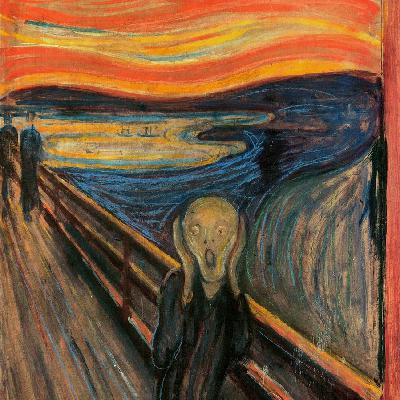

In [11]:
# Imagen que define el estilo
style_image = load_image(size=image_size, filename='images/scream.jpg')
show(style_image)

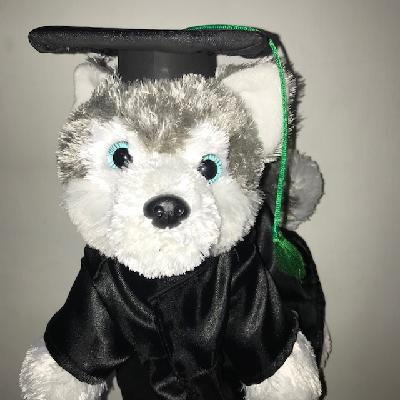

In [12]:
# Image to define the content
content_image = load_image(size=image_size, filename='images/colmillo.jpg')
show(content_image)

**Nota**: Para preservar el color en la imagen de contenido, se implementan las técnicas de https://arxiv.org/pdf/1606.05897.pdf. En particular, la coincidencia del histograma de color.

### Paso 2

Calcular las activaciones de las capas de estilo de la imagen de entrada de estilo, y las activaciones de la capa de contenido de la imagen de entrada de contenido.

In [13]:
# Calculamos las activaciones del estilo
style_layers_computed = sess.run(
    style_layers,
    feed_dict={input_tensor: preprocess(style_image)})

In [14]:
# Calculamos las activaciones del contenido
content_layers_computed = sess.run(
    content_layers,
    feed_dict={input_tensor: preprocess(np.expand_dims(content_image, 0))})

### Paso 3

Revisamos la diferencia entre las capas de estilo de la imagen resultante y las capas de estilo de la imagen de entrada de estilo.

In [15]:
def style_loss(current, computed):
    '''Definimos la pérdida de estilo entre un tensor y un arreglo de numpy
    Args:
        current: tf.Tensor. Las activaciones de estilo de la imagen actual.
        computed: np array. Las activaciones de estilo de la imagen de estilo dada.
    '''
    style_losses = []
    for layer1, layer2 in zip(current, computed):
        _, height, width, number = map(lambda i: i, layer2.shape)
        size = height * width * number

        # Calculamos la capa 1
        feats1 = tf.reshape(layer1, (-1, number))
        layer1_gram = tf.matmul(tf.transpose(feats1), feats1) / size
        # Calculamos la capa 2
        feats2 = tf.reshape(layer2, (-1, number))
        layer2_gram = tf.matmul(tf.transpose(feats2), feats2) / size

        dim1, dim2 = map(lambda i: i.value, layer1_gram.get_shape())
        loss = tf.sqrt(tf.reduce_sum(
            tf.square((layer1_gram - layer2_gram) / (number * number))))
        style_losses.append(loss)
    return tf.add_n(style_losses)

### Paso 4

Revisamos la diferencia entre las capas de contenido de la imagen resultante y las capas de contenido de la imagen de entrada de contenido.

In [16]:
def content_loss(current, computed):
    # Para una capa
    _, height, width, number = computed.shape
    size = height * width * number
    return tf.sqrt(tf.nn.l2_loss(current - computed) / size)

### Paso 5

Definimos la pérdida de varianza total (evita el ruido en el resultado), con el fin de mantener la imagen generada coherente (localmente). https://en.wikipedia.org/wiki/Total_variation_denoising

In [17]:
def total_variation_loss(image, image_shape=None):
    if image_shape:
        width, height, channels = image_shape
    else:
        # Se intenta obtener el tamaño de la imagen por medio del tensor
        dims = image.get_shape()
        width = dims[1].value
        height = dims[2].value
        channels = dims[3].value

    tv_x_size = width * (height - 1) * channels
    tv_y_size = (width - 1) * height * channels

    return (
        tf.reduce_sum(tf.abs(image[:, 1:, :, :] - image[:, :-1, :, :])) +
        tf.reduce_sum(tf.abs(image[:, :, 1:, :] - image[:, :, :-1, :]))
    )

### Paso 6

Definir el gradiente para cambiar la imagen del resultado con el fin de minimizar la pérdida total. Donde:

Pérdida total = pérdida de estilo + pérdida de contenido + pérdida de varianza total.

In [18]:
def setup_gradient(input_tensor, result_tensor):
    '''Configuramos el gradiente del tensor de entrada al tensor resultante.
    Args: 
        input_tensor: Tensor de entrada
        result_tensor: El tensor que queremos maximizar.
    '''
    # Obtenemos la media del result_tensor
    excitement_score = tf.reduce_mean(result_tensor)

    #Los degradados nos dan cómo cambiar la entrada (input_tensor)
    # para aumentar el excitement_score.
    gradient = tf.gradients(excitement_score, input_tensor)[0]

    return gradient, excitement_score

In [19]:
# Cuánto contenido, estilo y pérdida de varianza total contribuyen a la pérdida total.
content_weight = 1e3
style_weight = 1e6
tv_weight = 1e-2

In [20]:
# Configuramos el estilo, el contenido, la variación total, y pérdida total
# para usarlos para definir el gradiente.
with graph.as_default():
    with graph.name_scope("style_loss") as scope:
        style_loss_op = style_weight * \
            style_loss(style_layers, style_layers_computed)
    with graph.name_scope("content_loss") as scope:
        content_loss_op = content_weight * \
            content_loss(content_layers, content_layers_computed)
    with graph.name_scope("tv_loss") as scope:
        tv_loss_op = tv_weight * total_variation_loss(input_tensor)
    with graph.name_scope("loss") as scope:
        total_loss_op = style_loss_op + content_loss_op + tv_loss_op
    with graph.name_scope("gradient") as scope:
        gradient_op, score_op = setup_gradient(input_tensor, total_loss_op)

### Paso 7

Modificamos la imagen del resultado con el gradiente para un número de iteraciones.

Definimos los procesos de optimización

In [21]:
def get_uninitialized_variables(variables=None, session=None):
    """
        Obtenemos variables no inicializadas en una sesión como una lista.
        Args: 
            variables: Lista de tf.Variable. Obtenemos vars sin inicializar a partir de estos. 
                       Si no hay ninguno, obtenemos todos los vars sin inicializar en la sesión. 
            session: tf.Session para encontrar vars no inicializados. Si no hay ninguno
                     usa la sesión default.
        Returns:
            Variables no inicializadas dentro de "variables".
            Si no se especifica "variables", devuelve todas las variables no inicializadas.
    """
    if not session:
        session = tf.get_default_session()
    if variables is None:
        variables = tf.global_variables()
    else:
        variables = list(variables)
    init_flag = session.run(
        tf.stack([tf.is_variable_initialized(v) for v in variables]))
    return [v for v, f in zip(variables, init_flag) if not f]

In [22]:
def initialize_variables():
    '''Inicializamos las variables internas que utiliza el optimizador.
       Podríamos usar tf.global_variables_initializer (). Eval () para
       inicializar todas las variables, pero esto arruina el modelo de Keras
    '''
    #Obtenemos las vars no inicializadas y sus inicializadores
    uninitialized_vars = get_uninitialized_variables()
    initializers = [var.initializer for var in uninitialized_vars]

    #Imprimimos las variables no inicializadas
    print('Uninitialized variables:')
    print([initializer.name for initializer in initializers])

    #Inicializamos las variables
    _ = [initializer.run() for initializer in initializers]

def init_input(show_image=False):
    ''' Definimos la imagen de inicio en el tensor de entrada.
        La imagen con la que vamos a comenzar es la imagen de contenido,
        con peturbaciones al azar (necesario, de lo contrario la pérdida de TV (total
        variation) converge a nan)
    Args:
        show_image: Indica si se imprime o no la imagen.
    '''
    # Definimos una imagen aleatoria de 0 a 1 con tamaño(batch_size, image_size, channels)
    initial_random = tf.random_normal(
        mean=1, stddev=.01, shape=(1,) + image_size + (3,))

    # Usamos la imagen del contenido
    initial_content = preprocess(np.expand_dims(content_image, axis=0))

    # Inicializamos el tensor de entrada
    input_tensor.initializer.run()
    input_tensor.assign(
        tf.clip_by_value(initial_content * initial_random, 0, 255)
    ).eval()

    # Mostramos el tensor de entrada
    if show_image:
        show(np.squeeze(input_tensor.eval()))


# Ayuda para imprimir las pérdidas
def print_progress(i,
                   iterations,
                   loss_computed,
                   style_loss_computed,
                   content_loss_computed,
                   tv_loss_computed):
    print('Iteration %d/%d Content L: %g Style L: %g TV L: %g Total L: %g' % (
        i,
        iterations,
        content_loss_computed,
        style_loss_computed,
        tv_loss_computed,
        loss_computed
    ))

In [23]:
def run_optimization(train_step, iterations=500, print_n_times=10):
    ''' Corremos el optimizador un número especifico de iteraciones
    Args:
        train_step: La operación que se ejecuta en cada iteración.
        iterations: Veces que ejecutamos la optimización. 
            Recomendado al menos 500 - 1000 iteraciones para una imagen de buena calidad. 
            Sin embargo, un buen estilo es visible incluso después de 100 iters.
        print_n_times: Int, Cuántas veces imprimir el progreso.
    Return:
        Una lista de pérdidas durante la optimización de la forma: 
        [(tiempo transcurrido, pérdida)]
    '''
    if print_n_times == 0:
        # No imprimimos todas
        print_every_n = iterations + 1
    else:
        print_every_n = max(iterations // print_n_times, 1)

    # Nos quedamos solo con la imagen con menor pérdida.
    best_loss = float('inf')
    best = None

    losses = []

    # Calculamos el tiempo total de optimización
    start_time = time.time()

    # ciclo de optimización
    for i in range(iterations):
        # Mantenemos input_tensor entre 0 y 255

        # Corremos el training (train_step), y obtenemos las pérdidas
        (_, result_image, loss_computed,
         style_loss_computed, content_loss_computed,
         tv_loss_computed) = sess.run(
            [train_step, input_tensor, score_op, style_loss_op, content_loss_op,
             tv_loss_op])

        wall_time = time.time() - start_time

        losses.append((wall_time, loss_computed))

        # Imprimimos el progreso
        if i % print_every_n == 0:
            print_progress(i, iterations, loss_computed,
                           style_loss_computed, content_loss_computed,
                           tv_loss_computed)

    total_time = time.time() - start_time
    print ('Training took {:.0f} seconds or {:.2f} s/iteration !'.format(
        wall_time,
        wall_time / iterations))

    return losses

def optimize(optimizer, iterations=500, new_image=True):
    ''' Definimos y corremos la optimización
    Args:
        optimizer: El optimizador que vamos a usar
        iterations: Número de iteraciones
        new_image: Si empezamos con una nueva imagen o no
    Return: 
        Una lista de pérdidas durante la optimización de la siguiente manera: 
        [(tiempo transcurrido, pérdida)]
        La imagen
    '''
    with graph.as_default():
        # Calculamos los gradientes para obtener una lista de variables.
        grads_and_vars = optimizer.compute_gradients(score_op, [input_tensor])
        # Operación que le pide al optimizador que aplique los gradientes.
        train_step = optimizer.apply_gradients(grads_and_vars)

        initialize_variables()
        if new_image:
            init_input()
        losses = run_optimization(
            train_step, iterations=iterations, print_n_times=5)
        result_image = input_tensor.eval()
        result_image = np.clip(deprocess(result_image), 0, 255)
        show(result_image)
        return losses, result_image

## Prueba de distintos métodos

In [24]:
def save_results(optimizer_name, loss=None, result_image=None):
    '''Ayuda a guardar los resultados del optimizador resultante'''
    if result_image is not None:
        imsave('results/{}.jpg'.format(optimizer_name), result_image)
    if loss is None:
        # Checamos la pérdida
        loss = np.loadtxt('results/' + optimizer_name + '.csv')
    else:
        # Guardamos las pérdidas
        loss = np.asarray(loss)
        np.savetxt('results/' + optimizer_name + '.csv', np.asarray(loss))
    plot, = plt.plot(loss[:, 0], loss[:, 1])
    plotHandles.append(plot)
    labels.append(optimizer_name)

In [25]:
#Gráfica interactiva apagada
plt.ioff()
# Para agragar leyendas a la gráfica
figure = plt.figure(figsize=(15, 15))
labels = []
plotHandles = []
learning_rate = 10

## Método 1: Gradient Descent

Es un algoritmo de optimización iterativa de primer orden para encontrar el mínimo de una función. Para encontrar un mínimo local de una función usando la pendiente de gradiente, uno toma pasos proporcionales al negativo del gradiente (o gradiente aproximado) de la función en el punto actual. https://en.wikipedia.org/wiki/Gradient_descent

Uninitialized variables:
['model/Variable/Assign']
Iteration 0/500 Content L: 88422.2 Style L: 3.76244e+06 TV L: 40635.2 Total L: 3.8915e+06
Iteration 100/500 Content L: 117732 Style L: 1.14559e+06 TV L: 97883.1 Total L: 1.36121e+06
Iteration 200/500 Content L: 123332 Style L: 1.13842e+06 TV L: 104257 Total L: 1.36601e+06
Iteration 300/500 Content L: 123507 Style L: 1.42016e+06 TV L: 105366 Total L: 1.64903e+06
Iteration 400/500 Content L: 121147 Style L: 1.19601e+06 TV L: 102236 Total L: 1.4194e+06
Training took 1907 seconds or 3.81 s/iteration !


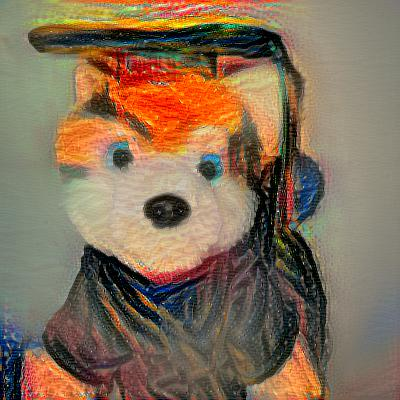

/Users/claudiameneses/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  after removing the cwd from sys.path.


In [26]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
loss, result_image = optimize(optimizer)
save_results(optimizer.get_name(), loss, result_image)

## Método 2 : Adagrad

Adagrad es un optimizador con tasas de aprendizaje de parámetros específicos, que se adaptan en función de la frecuencia con la que se actualiza un parámetro durante el entrenamiento. Cuantas más actualizaciones reciba un parámetro, menor será la tasa de aprendizaje. https://keras.io/optimizers/

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Uninitialized variables:
['model/Variable/Adagrad/Assign']
Iteration 0/500 Content L: 88429.6 Style L: 3.76252e+06 TV L: 40602.1 Total L: 3.89155e+06
Iteration 100/500 Content L: 116893 Style L: 787635 TV L: 94371.9 Total L: 998900
Iteration 200/500 Content L: 117951 Style L: 571437 TV L: 86761.5 Total L: 776150
Iteration 300/500 Content L: 117460 Style L: 455636 TV L: 80993.8 Total L: 654090
Iteration 400/500 Content L: 118304 Style L: 369697 TV L: 79820.2 Total L: 567821
Training took 1831 seconds or 3.66 s/iteration !


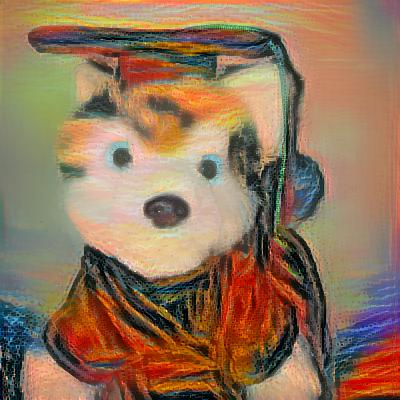

/Users/claudiameneses/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  after removing the cwd from sys.path.


In [27]:
optimizer = tf.train.AdagradOptimizer(learning_rate)
loss, result_image = optimize(optimizer)
save_results(optimizer.get_name(), loss, result_image)

## Método 3: Adam
Adam es un algoritmo de optimización que se puede utilizar en lugar del procedimiento clásico de descenso de gradiente estocástico para actualizar los pesos de red de forma iterativa en función de los datos de entrenamiento.

Uninitialized variables:
['beta1_power/Assign', 'beta2_power/Assign', 'model/Variable/Adam/Assign', 'model/Variable/Adam_1/Assign']
Iteration 0/500 Content L: 88424.7 Style L: 3.762e+06 TV L: 40623.1 Total L: 3.89104e+06
Iteration 100/500 Content L: 117237 Style L: 206100 TV L: 80158.5 Total L: 403496
Iteration 200/500 Content L: 115327 Style L: 142983 TV L: 79951.2 Total L: 338261
Iteration 300/500 Content L: 112783 Style L: 156309 TV L: 79823 Total L: 348915
Iteration 400/500 Content L: 110721 Style L: 138094 TV L: 74266.6 Total L: 323082
Training took 2027 seconds or 4.05 s/iteration !


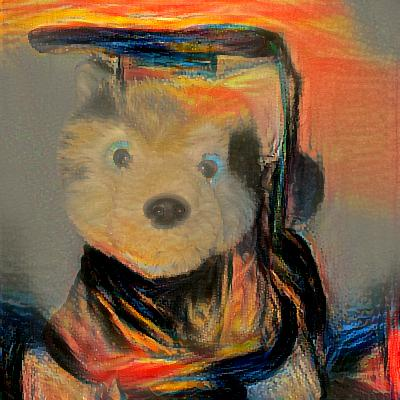

/Users/claudiameneses/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  after removing the cwd from sys.path.


In [28]:
optimizer = tf.train.AdamOptimizer(learning_rate)
loss, result_image = optimize(optimizer)
save_results(optimizer.get_name(), loss, result_image)

## Método 4: RMSprop

El optimizador RMSprop es similar al algoritmo de Gradient Descent con momentum. El optimizador RMSprop restringe las oscilaciones en la dirección vertical. Por lo tanto, podemos aumentar la tasa de aprendizaje y el algoritmo puede dar pasos más grandes en la dirección horizontal para que converja más rápido. La diferencia entre RMSprop y el Gradient Descent se basa en cómo se calculan los gradientes. https://towardsdatascience.com/a-look-at-gradient-descent-and-rmsprop-optimizers-f77d483ef08b

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Uninitialized variables:
['model/Variable/RMSProp/Assign', 'model/Variable/RMSProp_1/Assign']
Iteration 0/500 Content L: 88456.7 Style L: 3.76251e+06 TV L: 40632.5 Total L: 3.8916e+06
Iteration 100/500 Content L: 131199 Style L: 1.73491e+06 TV L: 142452 Total L: 2.00856e+06
Iteration 200/500 Content L: 119097 Style L: 1.26007e+06 TV L: 87733.6 Total L: 1.4669e+06
Iteration 300/500 Content L: 134568 Style L: 1.31692e+06 TV L: 135208 Total L: 1.5867e+06
Iteration 400/500 Content L: 131334 Style L: 1.17469e+06 TV L: 122863 Total L: 1.42889e+06
Training took 1846 seconds or 3.69 s/iteration !


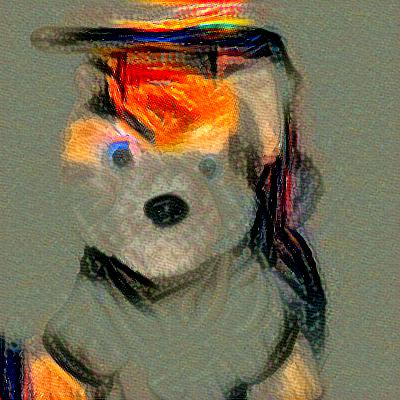

/Users/claudiameneses/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  after removing the cwd from sys.path.


In [29]:
optimizer = tf.train.RMSPropOptimizer(learning_rate)
loss, result_image = optimize(optimizer)
save_results(optimizer.get_name(), loss, result_image)

## Método  5 : Stochastic Gradient Descent con momentum

SGD es un método iterativo para optimizar una función objetivo con propiedades de suavidad adecuadas (por ejemplo, diferenciables o subdifferebles ). Puede considerarse como una aproximación estocástica de la optimización del descenso del gradiente , ya que reemplaza el gradiente real (calculado a partir del conjunto de datos completo ) por una estimación del mismo (calculado a partir de un subconjunto de datos seleccionado al azar). La idea básica detrás de la aproximación estocástica se remonta al algoritmo Robbins-Monro de la década de 1950, el descenso de gradiente estocástico se ha convertido en un método de optimización importante.


SGD con momentum recuerda la actualización Δw en cada iteración, y determina la próxima actualización como una combinación lineal del gradiente y la actualización anterior. Para más información: https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum

Uninitialized variables:
['model/Variable/Momentum/Assign']
Iteration 0/500 Content L: 88431.1 Style L: 3.76272e+06 TV L: 40608 Total L: 3.89176e+06
Iteration 100/500 Content L: 117057 Style L: 1.06162e+06 TV L: 97463.7 Total L: 1.27614e+06
Iteration 200/500 Content L: 121381 Style L: 1.22221e+06 TV L: 102963 Total L: 1.44655e+06
Iteration 300/500 Content L: 121313 Style L: 858757 TV L: 102052 Total L: 1.08212e+06
Iteration 400/500 Content L: 119525 Style L: 1.05331e+06 TV L: 101008 Total L: 1.27384e+06
Training took 1979 seconds or 3.96 s/iteration !


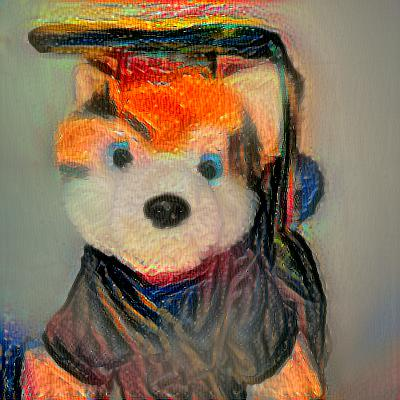

/Users/claudiameneses/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  after removing the cwd from sys.path.


In [30]:
optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.0)
loss, result_image = optimize(optimizer)
save_results(optimizer.get_name(), loss, result_image)

## Comparación de Optimizadores

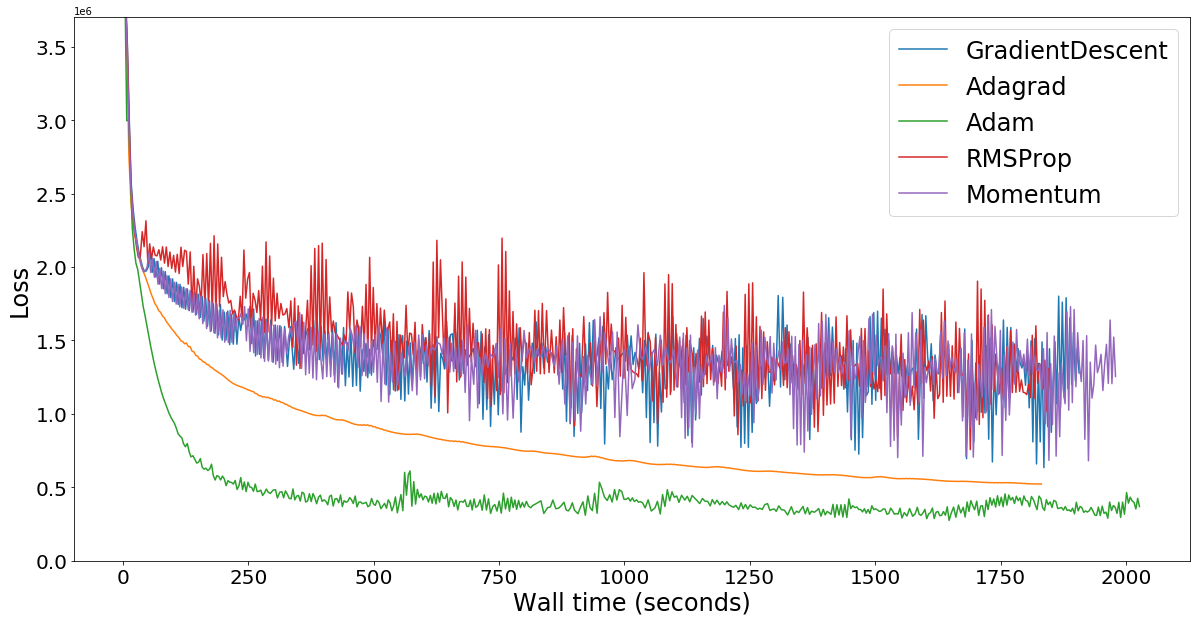

In [52]:
figure.set_size_inches(20, 10, forward=True)
plt.legend(plotHandles, labels, prop={'size': 24})
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.tick_params(labelsize=20)
plt.xlabel('Wall time (seconds)', fontsize=24)
plt.ylabel('Loss', fontsize=24)
plt.ylim([0, 3.7e+6])
figure